<a href="https://colab.research.google.com/github/khanhtran0259/PotatoDiseases/blob/main/PotatoDiseases_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!kaggle datasets download -d hafiznouman786/potato-plant-diseases-data

Dataset URL: https://www.kaggle.com/datasets/hafiznouman786/potato-plant-diseases-data
License(s): CC0-1.0
 86% 65.0M/75.7M [00:01<00:00, 69.4MB/s]
100% 75.7M/75.7M [00:01<00:00, 70.4MB/s]


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/potato-plant-diseases-data.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [3]:
import os
for dirpath , dirname, filename in os.walk('PlantVillage'):
  print(f"There are  {len(dirname)} directories and {len(filename)} image in '{dirpath}'.")

There are  1 directories and 0 image in 'PlantVillage'.
There are  3 directories and 0 image in 'PlantVillage/PlantVillage'.
There are  0 directories and 152 image in 'PlantVillage/PlantVillage/Potato___healthy'.
There are  0 directories and 1000 image in 'PlantVillage/PlantVillage/Potato___Early_blight'.
There are  0 directories and 1000 image in 'PlantVillage/PlantVillage/Potato___Late_blight'.


In [4]:
import shutil
import random
#/content/PlantVillage/PlantVillage/Potato___healthy
# Set the seed for reproducibility
random.seed(42)
base_dir = '/content/PlantVillage/PlantVillage'
categories = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
output_dirs = ['train', 'val', 'test']

In [5]:
for output_dir in output_dirs:
    for category in categories:
        os.makedirs(os.path.join(base_dir, output_dir, category), exist_ok=True)

# Split data
for category in categories:
    category_path = os.path.join(base_dir, category)
    images = os.listdir(category_path)
    random.shuffle(images)

    train_split = int(0.8 * len(images))
    val_split = int(0.1 * len(images)) + train_split

    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]

    for image in train_images:
        train_dir = os.path.join(base_dir, 'train', category)
        if not os.path.exists(train_dir):
            os.makedirs(train_dir)
        shutil.copy(os.path.join(category_path, image), os.path.join(train_dir, image))

    for image in val_images:
        val_dir = os.path.join(base_dir, 'val', category)
        if not os.path.exists(val_dir):
            os.makedirs(val_dir)
        shutil.copy(os.path.join(category_path, image), os.path.join(val_dir, image))

    for image in test_images:
        test_dir = os.path.join(base_dir, 'test', category)
        if not os.path.exists(test_dir):
            os.makedirs(test_dir)
        shutil.copy(os.path.join(category_path, image), os.path.join(test_dir, image))

print("Done.")

Done.


In [6]:
train_dir = '/content/PlantVillage/PlantVillage/train'
val_dir = '/content/PlantVillage/PlantVillage/val'
test_dir = '/content/PlantVillage/PlantVillage/test'

In [7]:
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_name = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_name)

['Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy']


In [8]:
#function visualize image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
def view_random_image(target_dir, target_class):
  #target dir
  target_folder = target_dir+"/"+target_class
  #Get random img
  random_img = random.sample(os.listdir(target_folder), 1)
  # read and plot image
  img = mpimg.imread(target_folder+ "/" +   random_img[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  #show img shape
  print(f"Image shape: {img.shape}")
  return img

Image shape: (256, 256, 3)


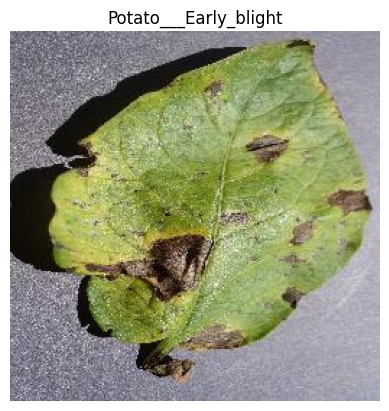

In [9]:
img = view_random_image(target_dir = train_dir, target_class=random.choice(class_name))

###Preprocessing image


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#rescale image
train_data_gen = ImageDataGenerator(rescale=1/255.)
val_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)

#
train_data = train_data_gen.flow_from_directory(train_dir, target_size=(224,224), batch_size = 32, class_mode='categorical')
val_data = val_data_gen.flow_from_directory(val_dir, target_size=(224,224), batch_size = 32, class_mode='categorical')
test_data = test_data_gen.flow_from_directory(test_dir, target_size=(224,224), batch_size = 32, class_mode='categorical')


Found 1721 images belonging to 3 classes.
Found 215 images belonging to 3 classes.
Found 216 images belonging to 3 classes.


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation

#build model
model = Sequential([
    Conv2D(10, 3, input_shape=(224,224,3)),
    Activation(activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(3, activation='softmax')
])

In [12]:
#Compile model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [13]:
#Fit the model
history = model.fit(train_data, epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data))

Epoch 1/5
54/54 [==============================] - 16s 183ms/step - loss: 0.6636 - accuracy: 0.7141 - val_loss: 0.4445 - val_accuracy: 0.8140
Epoch 2/5
54/54 [==============================] - 4s 71ms/step - loss: 0.2553 - accuracy: 0.9018 - val_loss: 0.1745 - val_accuracy: 0.9256
Epoch 3/5
54/54 [==============================] - 4s 66ms/step - loss: 0.1508 - accuracy: 0.9483 - val_loss: 0.1072 - val_accuracy: 0.9721
Epoch 4/5
54/54 [==============================] - 4s 83ms/step - loss: 0.0872 - accuracy: 0.9733 - val_loss: 0.0922 - val_accuracy: 0.9581
Epoch 5/5
54/54 [==============================] - 4s 67ms/step - loss: 0.0599 - accuracy: 0.9785 - val_loss: 0.1172 - val_accuracy: 0.9442


In [14]:
model.evaluate(test_data)

7/7 [==============================] - 1s 99ms/step - loss: 0.1739 - accuracy: 0.9537


[0.17393308877944946, 0.9537037014961243]

In [15]:
#plot validation and training
def plot_loss_curves(history):
  loss= history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))

  #plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

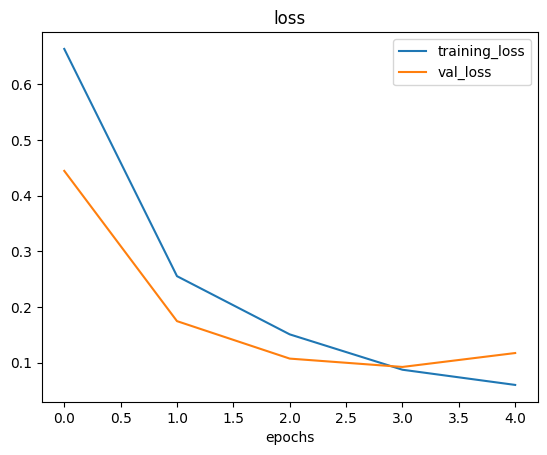

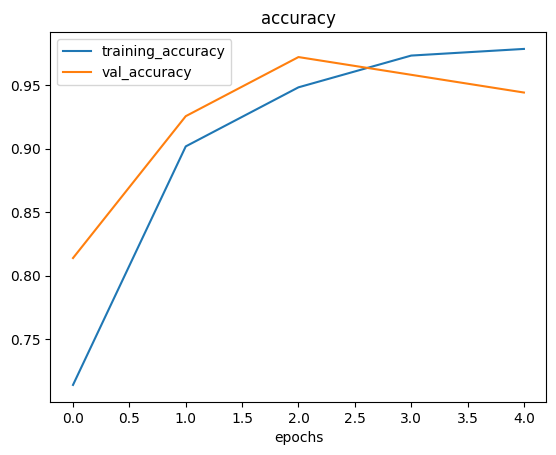

In [16]:
plot_loss_curves(history)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 activation (Activation)     (None, 222, 222, 10)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 10)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 conv2d_2 (Conv2D)           (None, 107, 107, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

In [18]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [19]:
def pred_plot(model, filename, class_name):
  img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))
  # Get the index of the class with the highest probability
  pred_class_index = tf.argmax(pred, axis=1)
  # Use the index to get the class name
  pred_class = class_name[pred_class_index]
  plt.imshow(img)
  plt.title(f"Prediction:{pred_class}")
  plt.axis(False)

In [20]:
#late blight
!wget https://cropscience.bayer.co.uk/media/104571097/late-blight-potato-plant.jpg?width=401px&height=301px
!wget https://spudsmart.com/wp-content/uploads/2017/05/potato_late-blight_08_zoom-Photo-OMAFRA-900x580.jpeg

#early blight
!wget https://vegpath.plantpath.wisc.edu/wp-content/uploads/sites/210/2023/11/potato-early-blight-leaves.jpg
!wget https://images.ctfassets.net/l2hapltrg3cz/32lFKOCYJtoBvt5LgoAHPz/9606e6c4529327971a84824f3e8fc52f/early-blight-potatoes.jpg

#healthy

!wget https://www.garden.eco/wp-content/uploads/2018/06/can-you-eat-potato-leaves.jpg
!wget https://previews.123rf.com/images/fotografiecor/fotografiecor1908/fotografiecor190800160/129024538-green-potato-plant-leaf-of-vegetable-organic-food-agriculture-in-garden-field-or-farm-growth-of-crop.jpg



--2024-06-03 17:06:30--  https://cropscience.bayer.co.uk/media/104571097/late-blight-potato-plant.jpg?width=401px
Resolving cropscience.bayer.co.uk (cropscience.bayer.co.uk)... 20.254.175.238
Connecting to cropscience.bayer.co.uk (cropscience.bayer.co.uk)|20.254.175.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 269381 (263K) [image/jpeg]
Saving to: ‘late-blight-potato-plant.jpg?width=401px’

late-blight-potato- 100%[===================>] 263.07K   563KB/s    in 0.5s    

2024-06-03 17:06:31 (563 KB/s) - ‘late-blight-potato-plant.jpg?width=401px’ saved [269381/269381]

--2024-06-03 17:06:31--  https://spudsmart.com/wp-content/uploads/2017/05/potato_late-blight_08_zoom-Photo-OMAFRA-900x580.jpeg
Resolving spudsmart.com (spudsmart.com)... 104.21.7.245, 172.67.188.28, 2606:4700:3036::6815:7f5, ...
Connecting to spudsmart.com (spudsmart.com)|104.21.7.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105807 (103K) [image/jpeg]
Saving

1/1 [==============================] - 0s 343ms/step


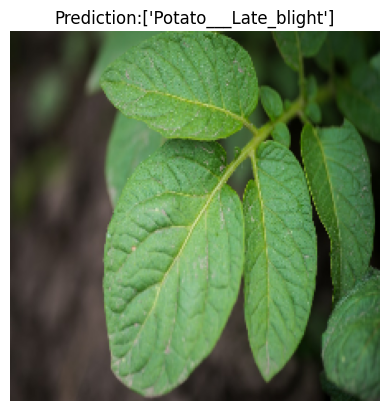

In [21]:
pred_plot(model, '/content/can-you-eat-potato-leaves.jpg', class_name)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

model_1 = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),

    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(3, activation='softmax')
])



In [23]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [25]:
history_1 = model.fit(train_data, epochs=50,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data))

Epoch 1/50
54/54 [==============================] - 12s 217ms/step - loss: 0.3009 - accuracy: 0.8948 - val_loss: 1.3887 - val_accuracy: 0.4651
Epoch 2/50
54/54 [==============================] - 9s 165ms/step - loss: 0.1413 - accuracy: 0.9547 - val_loss: 2.5191 - val_accuracy: 0.4651
Epoch 3/50
54/54 [==============================] - 8s 149ms/step - loss: 0.1230 - accuracy: 0.9611 - val_loss: 3.2107 - val_accuracy: 0.4651
Epoch 4/50
54/54 [==============================] - 9s 161ms/step - loss: 0.1049 - accuracy: 0.9587 - val_loss: 3.6279 - val_accuracy: 0.4651
Epoch 5/50
54/54 [==============================] - 8s 150ms/step - loss: 0.0973 - accuracy: 0.9709 - val_loss: 3.8718 - val_accuracy: 0.4651
Epoch 6/50
54/54 [==============================] - 9s 162ms/step - loss: 0.0787 - accuracy: 0.9669 - val_loss: 6.4905 - val_accuracy: 0.4651
Epoch 7/50
54/54 [==============================] - 9s 173ms/step - loss: 0.1086 - accuracy: 0.9564 - val_loss: 4.2634 - val_accuracy: 0.4651
Epoch

In [26]:
model.evaluate(test_data)

7/7 [==============================] - 1s 188ms/step - loss: 1.2110 - accuracy: 0.8981


[1.210959792137146, 0.8981481194496155]

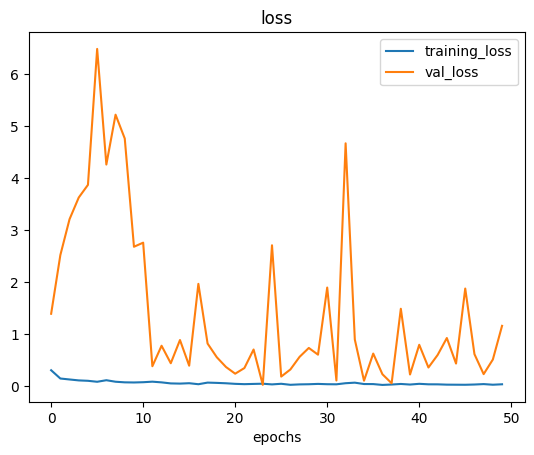

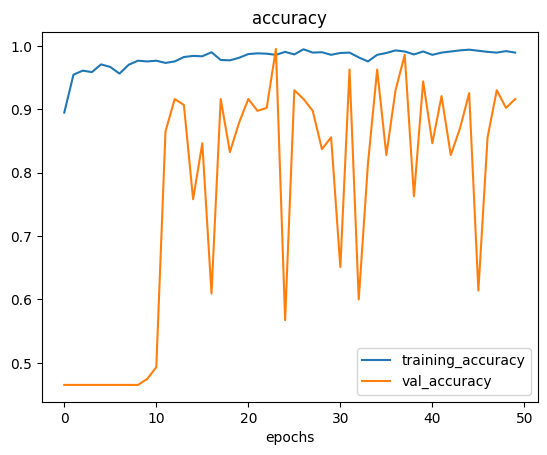

In [27]:
plot_loss_curves(history_1)

1/1 [==============================] - 0s 103ms/step


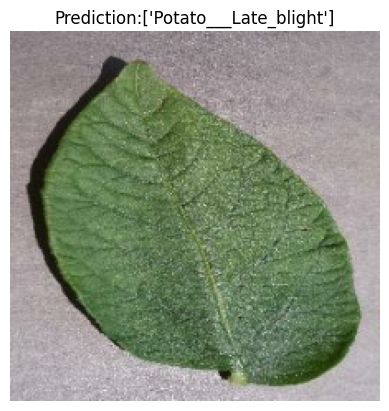

In [32]:
pred_plot(model, '/content/PlantVillage/PlantVillage/train/Potato___healthy/111cd9d8-4d27-4225-be9e-d29b21cf56b9___RS_HL 5419.JPG', class_name)